In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from weights import KernelComputer, KernelRegressor
from dataloader import Synthesizer
from regression import DF, IL, projection_il_ir, projection_df_ir

In [2]:
%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
n_train = 10
n_test = 200
exp_par, offset = 3, 1
corruption = exp_par, offset

datagen = Synthesizer('IR-' + str(n_train))
x_train, y_train = datagen.get_trainset()
x_test, y_test = datagen.get_testset(n_test)
S_train = datagen.synthetic_corruption(y_train, corruption, skewed=True)
c_train, r_train = S_train

In [4]:
def l2_loss(A, B):
    dist = A @ B.T
    dist *= -2
    dist += np.sum(A ** 2, axis=1)[:, np.newaxis]
    dist += np.sum(B ** 2, axis=1)
    return dist

In [5]:
kernel_type = 'Gaussian'  #
# kernel_type = "Laplacian"
# sigmas = [5, 1, 5e-1, 1e-1, 5e-2, 1e-2]
sigmas = [1e-1]
# lambdas = [1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9, 1e-12]
lambdas = [1e-1, 1e-3, 1e-6]

In [6]:
y_grid = np.linspace(-6, 6, num=1000)[:, np.newaxis]
IL_loss = l2_loss(c_train, y_grid)
IL_loss -= r_train[:, np.newaxis]
IL_loss[IL_loss < 0] = 0
IL_loss **= 2

In [7]:
kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train)

best_err_df, best_err_il, best_err_ac = 3 * (np.inf,)

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)
        
        alpha = kernel_reg(x_train)        
        y_dis = DF.disambiguation(alpha, S_train, 10e-6, 10e6, projection_df_ir)
        
        alpha = kernel_reg(x_test)
        alpha /= alpha.sum(axis=1)[:, np.newaxis]

        y_df = alpha @ y_dis
#         y_il = IL.disambiguation(alpha, S_train, 10e-6, 10e6, projection_il_ir)
        loss_grid = alpha @ IL_loss
        y_il = y_grid[np.argmin(loss_grid, axis=1)]
        y_ac = alpha @ c_train
        
        err_df = np.diag(l2_loss(y_df, y_test)).mean()
        err_il = np.diag(l2_loss(y_il, y_test)).mean()
        err_ac = np.diag(l2_loss(y_ac, y_test)).mean()
        
        if err_df < best_err_df:
            best_err_df = err_df
            best_y_df = y_df
            best_dis = y_dis
            best_s_df = sigma
            best_l_df = lambd
        if err_il < best_err_il:
            best_err_il = err_il
            best_y_il = y_il
            best_s_il = sigma
            best_l_il = lambd   
        if err_ac < best_err_ac:
            best_err_ac = err_ac
            best_y_ac = y_ac
            best_s_ac = sigma
            best_l_ac = lambd
        print('.', end='')

...

In [8]:
print(best_err_df, best_err_il, best_err_ac)
print(best_l_df, best_l_il, best_l_ac, best_s_df, best_s_il, best_s_ac)

0.45772941230991293 1.5965087304452326 0.9253577184469833
1e-06 0.1 0.1 0.1 0.1 0.1


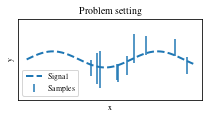

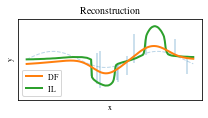

In [9]:
fig1, ax1 = plt.subplots(figsize=(3, 1.75))
a = ax1.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='none', color="C0")
b, = ax1.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=2, color="C0")
ax1.legend([b, a], [r"Signal", r"Samples"], prop={"size": 8}, loc='lower left', ncol=1)
ax1.set_title(r"Problem setting", size=10)

fig2, ax2 = plt.subplots(figsize=(3, 1.75))
ax2.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=1, color="C0", alpha=.3)
ax2.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='none', color="C0", alpha=.3)
# ax2.scatter(x_train.squeeze(), best_dis.squeeze(), color="C1", s=10)
b, = ax2.plot(x_test.squeeze(), best_y_il.squeeze(), linestyle="-", linewidth=2, color="C2")
a, = ax2.plot(x_test.squeeze(), best_y_df.squeeze(), linestyle="-", linewidth=2, color="C1")
ax2.legend([a, b], [r'DF', r'IL'], prop={'size': 8}, loc='lower left', ncol=1)
# c, = ax2.plot(x_test.squeeze(), best_y_ac.squeeze(), linestyle="-", linewidth=3, color="C3")
# ax2.legend([a, b, c], ['DF', 'IL', 'AC'], prop={'size':20})
ax2.set_title(r"Reconstruction", size=10)

for ax in [ax1, ax2]:
    ax.set_xlabel("x", size=8)
    ax.set_ylabel("y", size=8)
    ax.set_ylim(-5, 5)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)
    
fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('savings/ir/setting.pdf')
fig2.savefig('savings/ir/reconstruction.pdf')